#### 1. Install dependencies and setup

In [242]:
%pip install tensorflow opencv-python matplotlib

/bin/bash: /home/rocket_champ/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Note: you may need to restart the kernel to use updated packages.


In [243]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [244]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

##### 1.2 Load data

In [245]:
data = tf.keras.utils.image_dataset_from_directory("../processedDataSetAds/train")

Found 100 files belonging to 2 classes.


In [246]:
data_iterator = data.as_numpy_iterator()

In [247]:
batch = data_iterator.next()

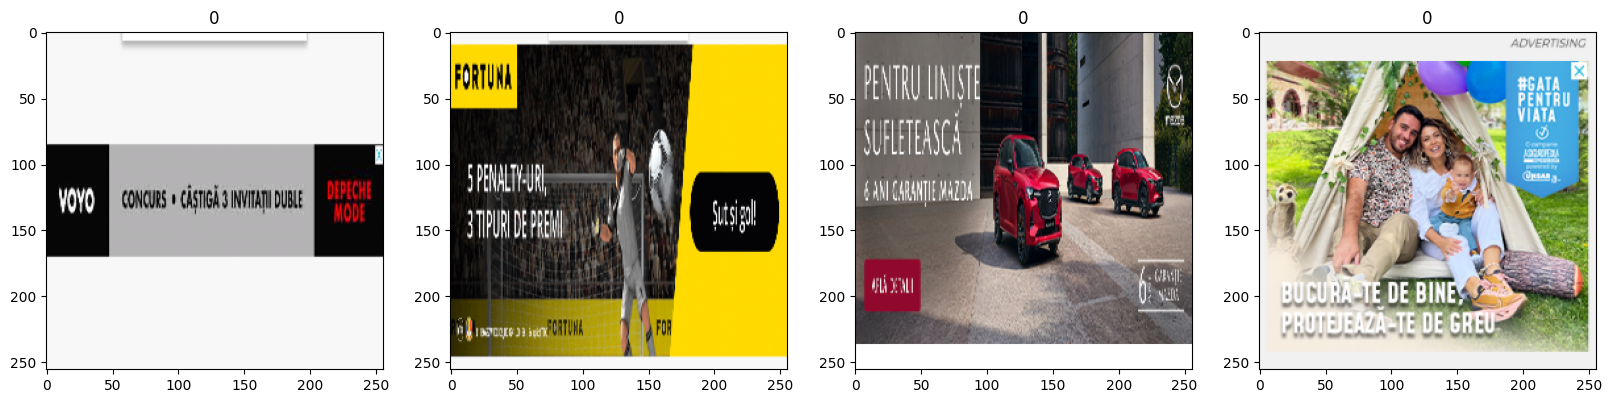

In [248]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see the labels will be: 
- 1 for Non Ad
- 0 for Ad

#### 2. Preprocessing

##### 2.1 Scale Data

In [249]:
data = data.map(lambda x, y: (x/255, y))

Check if data is normalized between 0 and 1 

In [250]:
data.as_numpy_iterator().next()[0].min()

0.0

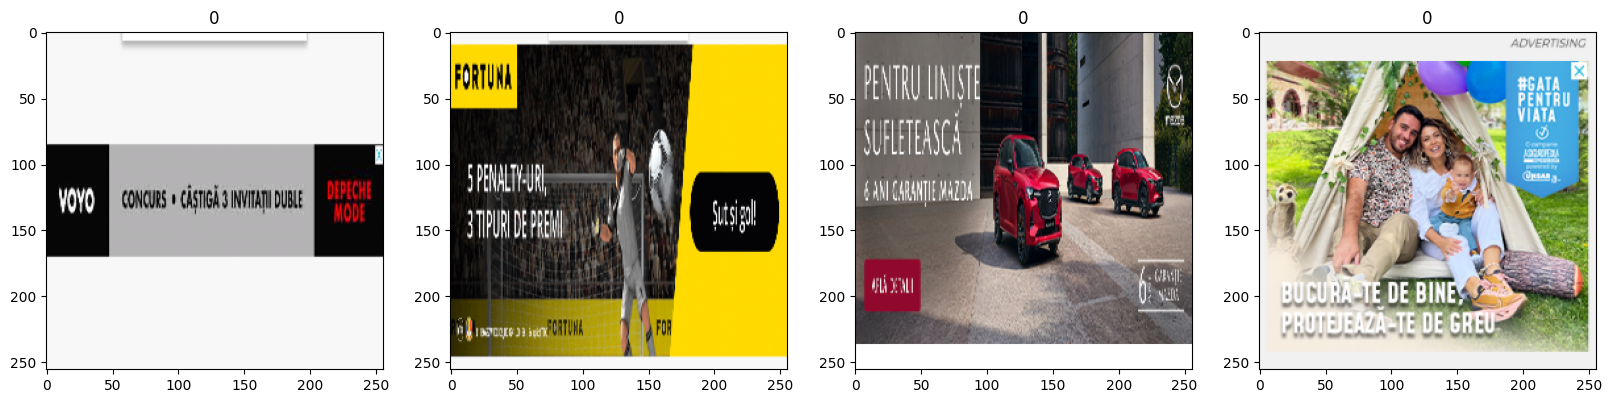

In [251]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### 2.2 Split Data 

Checking the length of our data in number of batches

In [252]:
len(data)

4

In [253]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [254]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [255]:
len(test)

1

#### 3. Deep Model

##### 3.1 Build the model

In [256]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [257]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [258]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 16)       

##### 3.2 Train

In [259]:
logdir='logs'

In [260]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [261]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2/2 [==============================] - 2s 423ms/step - loss: 0.8809 - accuracy: 0.5625 - val_loss: 0.6325 - val_accuracy: 0.7812
Epoch 2/20
2/2 [==============================] - 1s 258ms/step - loss: 0.7090 - accuracy: 0.5781 - val_loss: 0.6479 - val_accuracy: 0.6562
Epoch 3/20
2/2 [==============================] - 0s 194ms/step - loss: 0.6070 - accuracy: 0.7031 - val_loss: 0.6180 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 189ms/step - loss: 0.5722 - accuracy: 0.5625 - val_loss: 0.4728 - val_accuracy: 0.6250
Epoch 5/20
2/2 [==============================] - 0s 181ms/step - loss: 0.5392 - accuracy: 0.6094 - val_loss: 0.5228 - val_accuracy: 0.7812
Epoch 6/20
2/2 [==============================] - 0s 193ms/step - loss: 0.5110 - accuracy: 0.8594 - val_loss: 0.5273 - val_accuracy: 0.8750
Epoch 7/20
2/2 [==============================] - 0s 202ms/step - loss: 0.5607 - accuracy: 0.8125 - val_loss: 0.4238 - val_accuracy: 0.9062
Epoch 8/20
2/2 [===============

3.3 Plot Performance

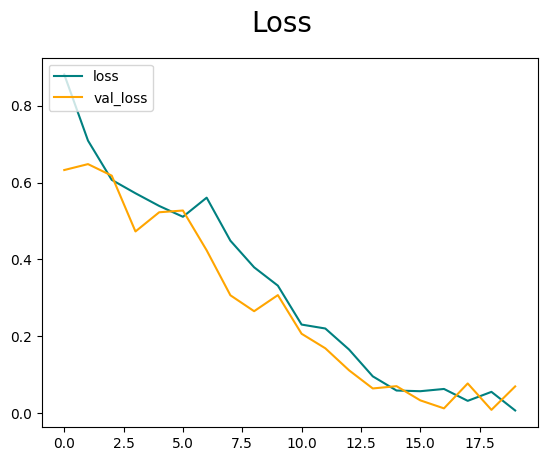

In [262]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

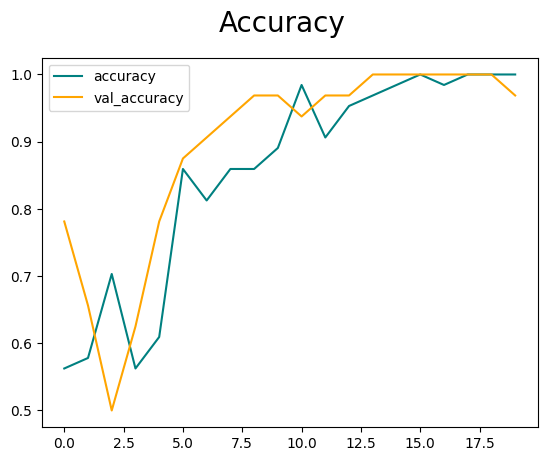

In [263]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### 4. Evaluate Performance

4.1 Evaluate

In [264]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [265]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [266]:
len(test)

1

In [267]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 45ms/step


In [268]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

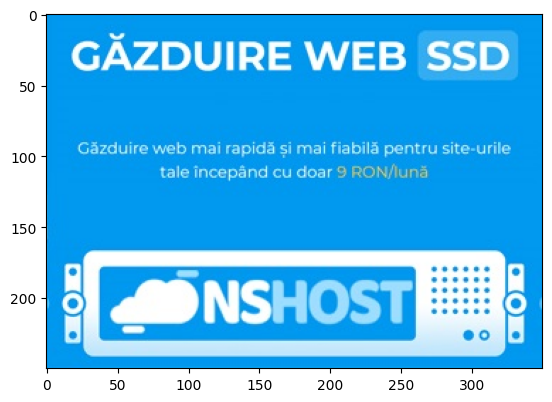

In [269]:
import cv2
img = cv2.imread('/mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/processedDataSetAds/ex_image.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

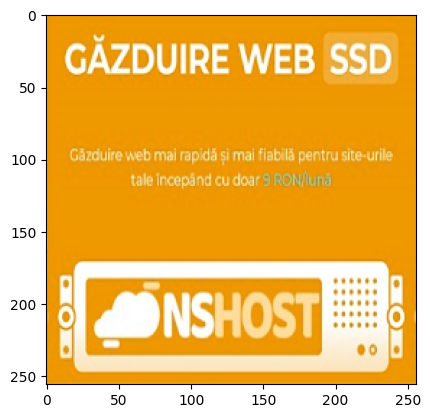

In [270]:
resized_image = tf.image.resize(img, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [271]:
yhat = model.predict(np.expand_dims(resized_image/255, 0))

1/1 [==============================] - 0s 18ms/step


In [272]:
if yhat < 0.5: 
    print(f'With a confidence of {int((abs(yhat-1)*100)[0][0])}%')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat*100)[0][0])}%')
    print(f'The image is NOT AD')


With a confidence of 92%
The image is NOT AD


Let's test it with a non-AD

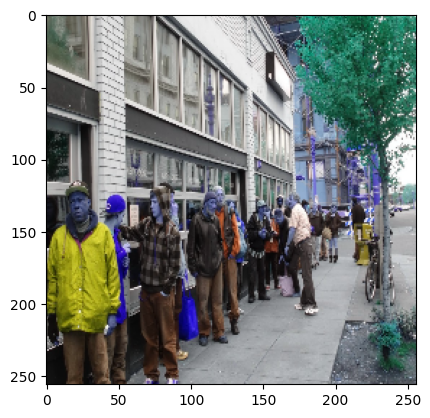

In [273]:
import cv2
img_non_ad = cv2.imread('/mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/processedDataSetAds/non_ad.jpg')
resized_nonad = tf.image.resize(img_non_ad, (256, 256))
plt.imshow(resized_nonad.numpy().astype(int))

In [274]:
yhat = model.predict(np.expand_dims(resized_nonad/255, 0))

1/1 [==============================] - 0s 20ms/step


In [275]:
if yhat < 0.5: 
    print(f'With a confidence of {int((abs(yhat-1)*100)[0][0])}%')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat*100)[0][0])}%')
    print(f'The image is NOT AD')


With a confidence of 99%
The image is AD


#### 5. Save the Model

##### 5.1 Save and Load the Model

In [276]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'adnonadmodel.h5'))
new_model = load_model(os.path.join('models', 'adnonadmodel.h5'))

/home/rocket_champ/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [277]:

yhat_new = new_model.predict(np.expand_dims(resized_nonad/255, 0))

1/1 [==============================] - 0s 46ms/step


In [278]:
if yhat_new < 0.5: 
    print(f'With a confidence of {int((abs(yhat_new-1)*100)[0][0])}percent')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat_new*100)[0][0])}percent')
    print(f'The image is NOT AD')

With a confidence of 99percent
The image is AD


In [280]:
!tensorflowjs_converter --input_format=keras /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/adnonadmodel.h5 /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/tfjs_model

UsageError: Line magic function `%tensorflowjs_converter` not found.
